# 데이터 정제 - 결측치(missing values)

In [14]:
# 실습 데이터 준비: openmv.net/info/travel-times

import pandas as pd
import io
import requests

df = pd.read_csv('https://openmv.net/file/travel-times.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            205 non-null    object 
 1   StartTime       205 non-null    object 
 2   DayOfWeek       205 non-null    object 
 3   GoingTo         205 non-null    object 
 4   Distance        205 non-null    float64
 5   MaxSpeed        205 non-null    float64
 6   AvgSpeed        205 non-null    float64
 7   AvgMovingSpeed  205 non-null    float64
 8   FuelEconomy     188 non-null    object 
 9   TotalTime       205 non-null    float64
 10  MovingTime      205 non-null    float64
 11  Take407All      205 non-null    object 
 12  Comments        24 non-null     object 
dtypes: float64(6), object(7)
memory usage: 20.9+ KB
None
       Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0  1/6/2012     16:37     Friday    Home     51.29     127.4      78.3   
1  1/6/2012   

In [15]:
print(df)

          Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0     1/6/2012     16:37     Friday    Home     51.29     127.4      78.3   
1     1/6/2012     08:20     Friday     GSK     51.63     130.3      81.8   
2     1/4/2012     16:17  Wednesday    Home     51.27     127.4      82.0   
3     1/4/2012     07:53  Wednesday     GSK     49.17     132.3      74.2   
4     1/3/2012     18:57    Tuesday    Home     51.15     136.2      83.4   
..         ...       ...        ...     ...       ...       ...       ...   
200  7/18/2011     08:09     Monday     GSK     54.52     125.6      49.9   
201  7/14/2011     08:03   Thursday     GSK     50.90     123.7      76.2   
202  7/13/2011     17:08  Wednesday    Home     51.96     132.6      57.5   
203  7/12/2011     17:51    Tuesday    Home     53.28     125.8      61.6   
204  7/11/2011     16:56     Monday    Home     51.73     125.0      62.8   

     AvgMovingSpeed FuelEconomy  TotalTime  MovingTime Take407All Comments 

### 1) 결측치 탐지
- isnull 함수 활용
- 히트맵 시각화
- klib, missingno, XeroGraph 활용
- 결측치 포함 변수의 상관관계 시각화

In [3]:
# isnull 활용
# 결측치 개수 확인
print(df.isnull().sum())

Date                0
StartTime           0
DayOfWeek           0
GoingTo             0
Distance            0
MaxSpeed            0
AvgSpeed            0
AvgMovingSpeed      0
FuelEconomy        17
TotalTime           0
MovingTime          0
Take407All          0
Comments          181
dtype: int64


In [5]:
# 결측치 비율 확인
missing_ratio = df.isnull().mean()
print(missing_ratio)

Date              0.000000
StartTime         0.000000
DayOfWeek         0.000000
GoingTo           0.000000
Distance          0.000000
MaxSpeed          0.000000
AvgSpeed          0.000000
AvgMovingSpeed    0.000000
FuelEconomy       0.082927
TotalTime         0.000000
MovingTime        0.000000
Take407All        0.000000
Comments          0.882927
dtype: float64


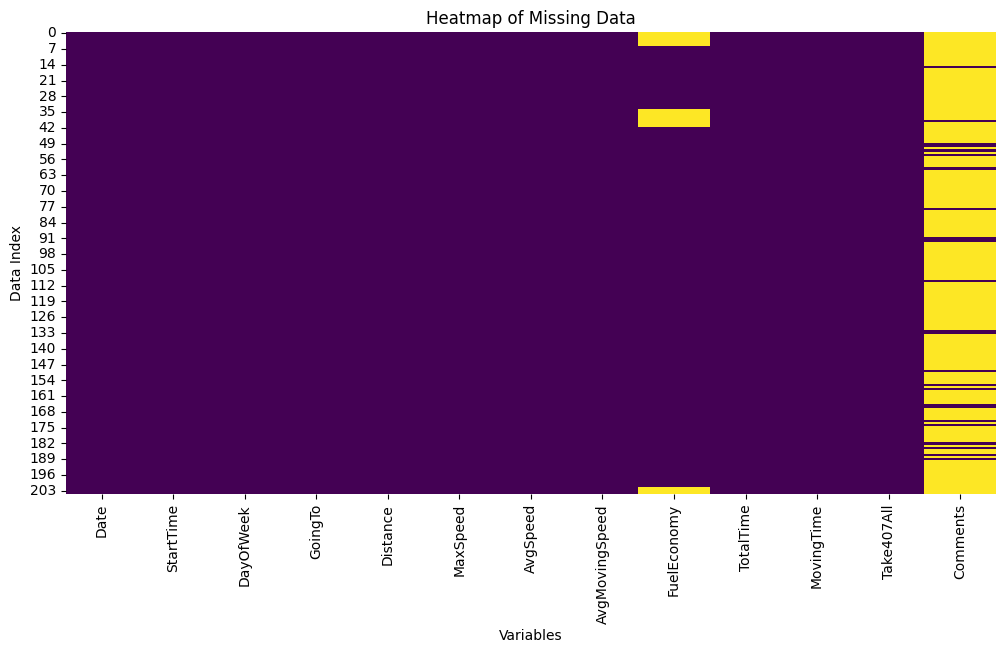

In [7]:
# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 결측치 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis') # 오른쪽에 색상 기준 표시(컬러 바)를 숨김
plt.xlabel('Variables')
plt.ylabel('Data Index')
plt.title('Heatmap of Missing Data')
plt.show()

#### 그래프 해석
- 완전 무작위 결측(Missing Completely At Random, MCAR)은 결측치가 무작위로 나타나야 하는데,17개 결측치가 일정한 길이로 연속 출현 -> MCAR 아님!
- 연속성을 보인다는 것은 Date 변수, 시계열성에 의한 결측치라는 사실 의심할 수 있음 -> MAR 가능성 높음(교통체증으로 연비 측정 불가능?)

In [8]:
# klib 활용
!pip install klib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [klib]n]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


GridSpec(6, 6)

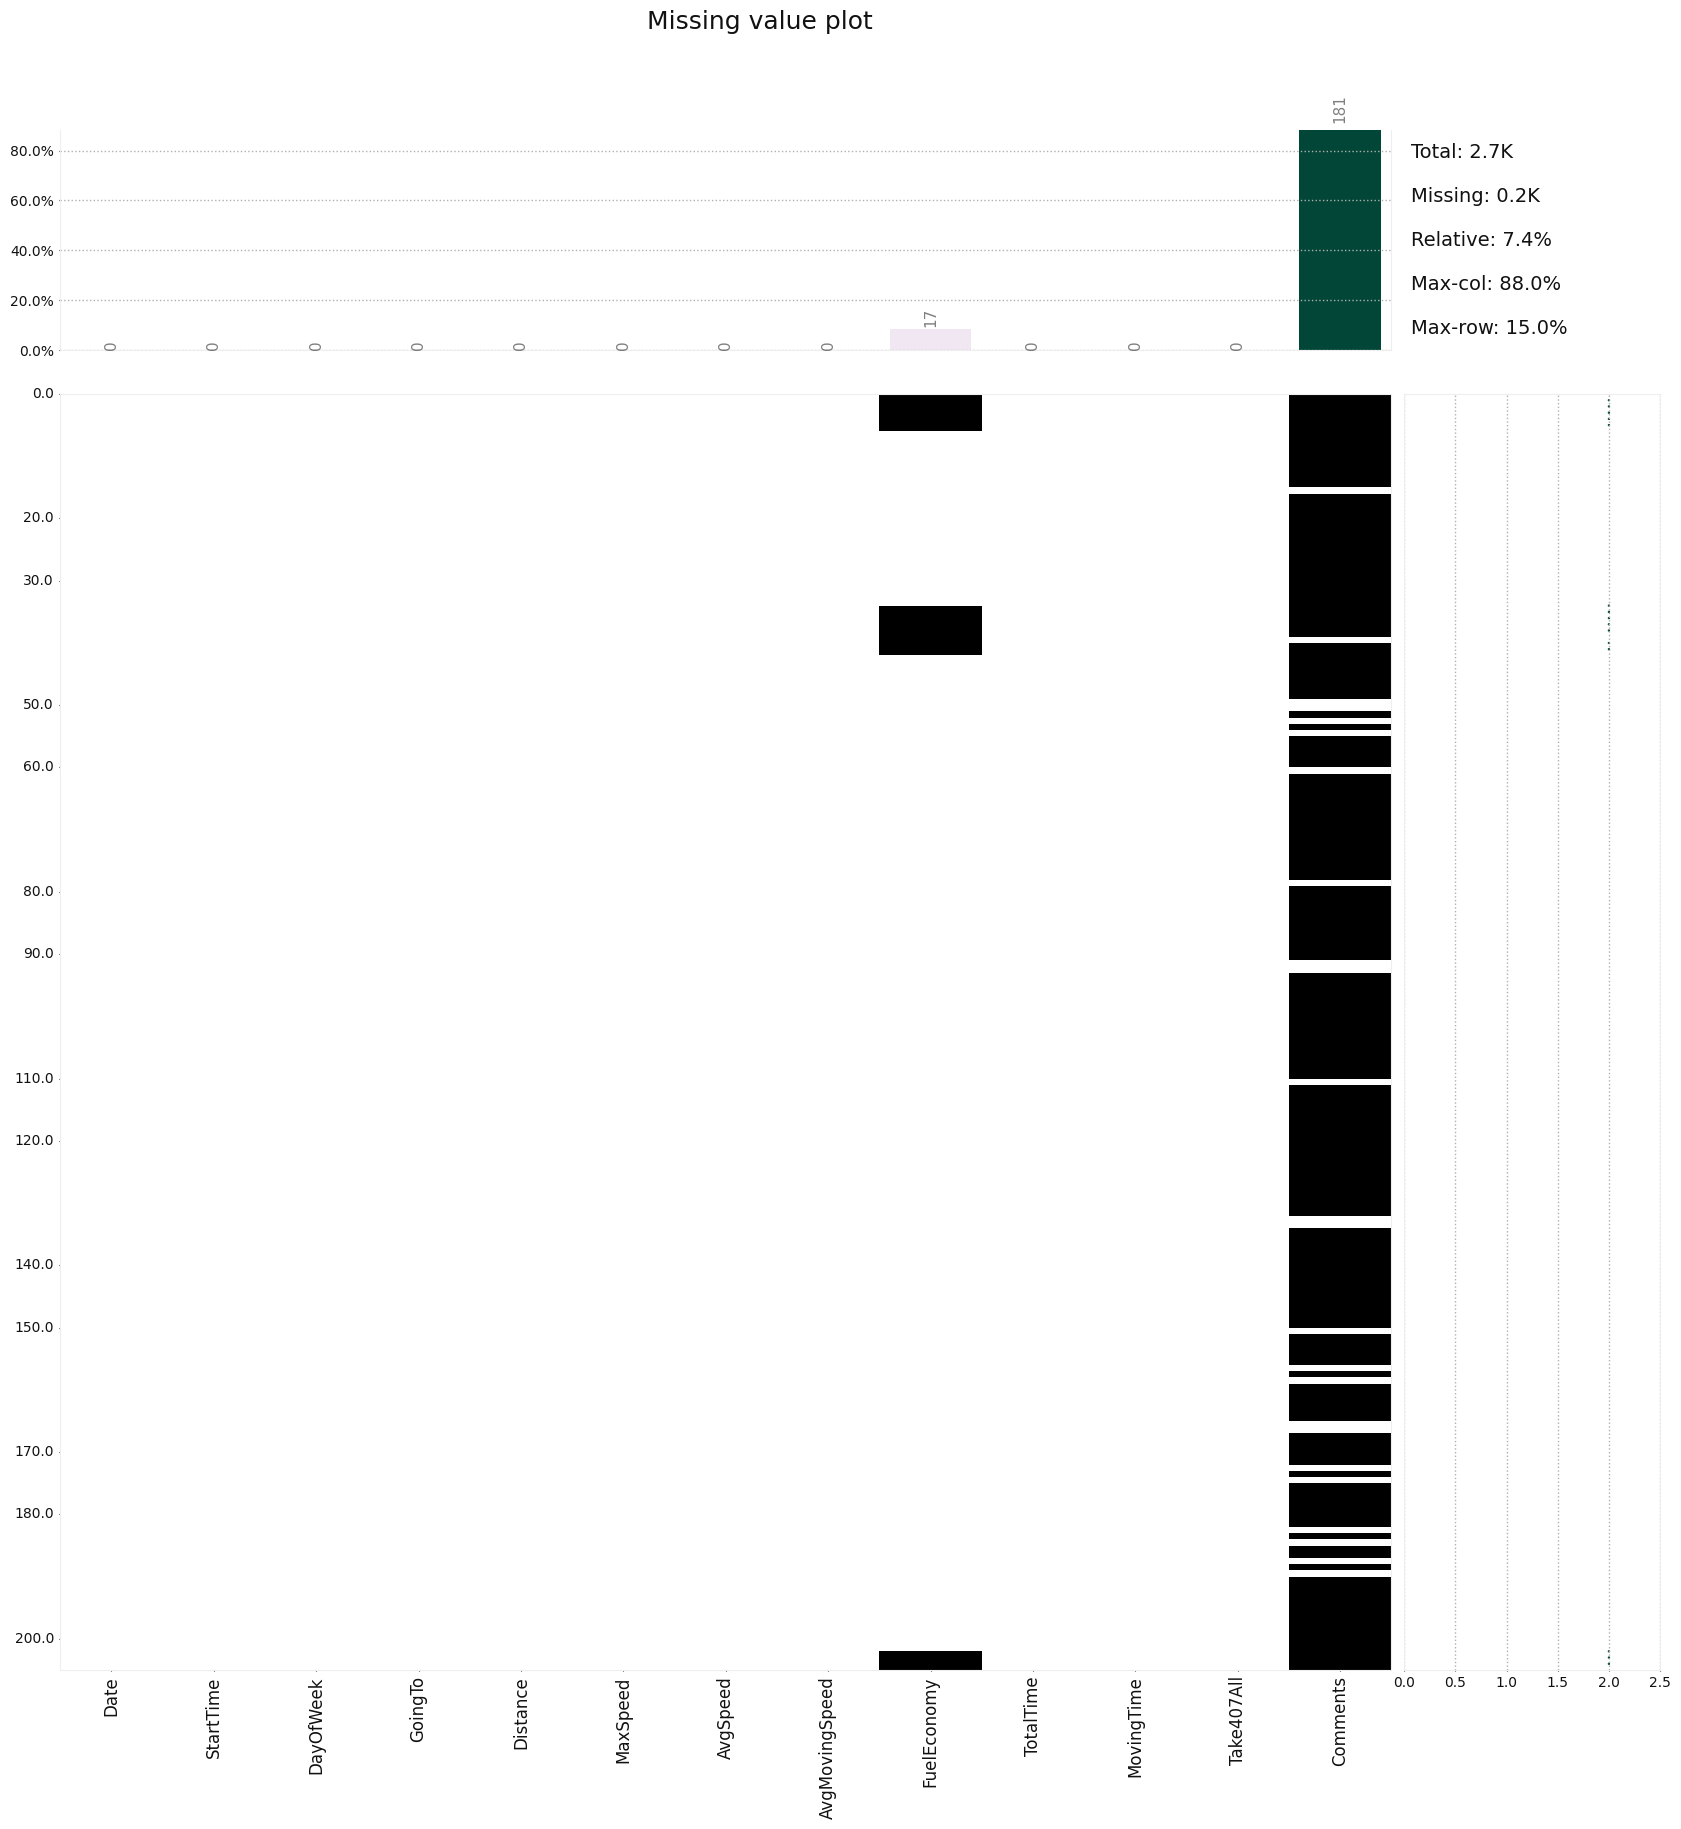

In [10]:
# 결측치의 수, 비율, 분포를 시각화
import klib

klib.missingval_plot(df)

<Axes: title={'center': 'Feature-correlation (pearson)'}>

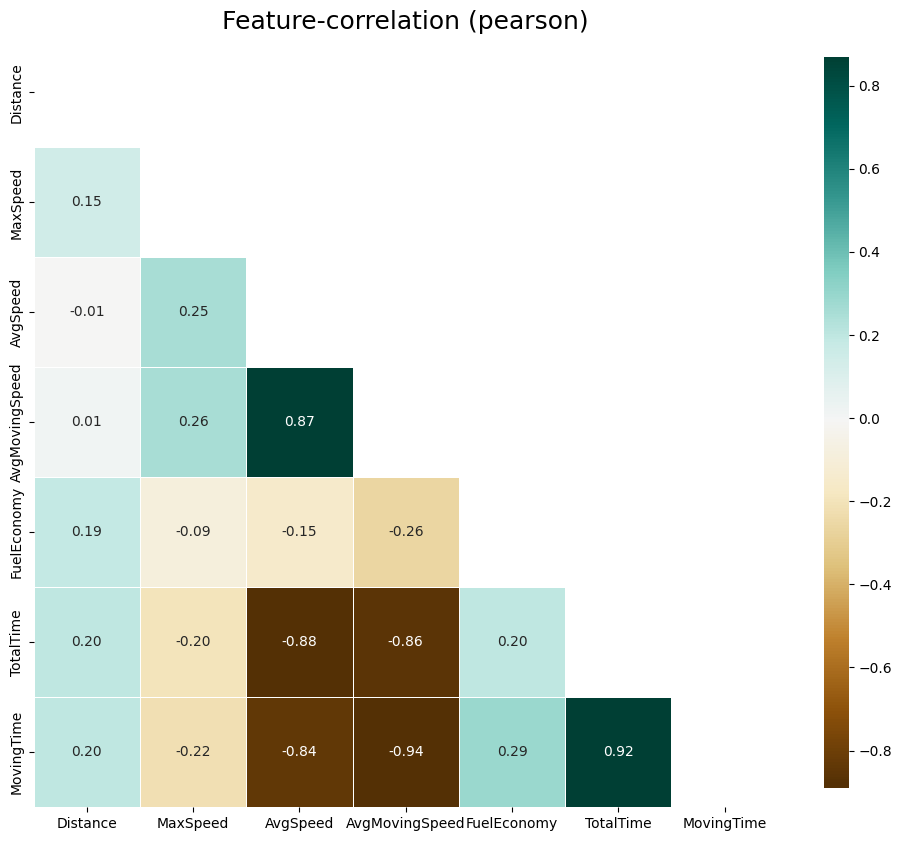

In [17]:
# MAR 가능성 확인! 다른 변수와의 상관관계는 수치형 데이터로 가능(자료형 형변환)
df['FuelEconomy'] = pd.to_numeric(df['FuelEconomy'], errors='coerce') # 숫자로 변환 안 되는 값은 전부 NaN(결측값)으로!

klib.corr_plot(df)
# klib.corr_plot(df, target=df['FuelEconomy'])

#### 그래프 해석
- FuelEconomy(연비)가 특별히 높은 상관관계를 가지는 수치형 변수는 없음! -> MovingTime(운행일시)를 제외한 변수에 의한 MAR을 의심하기 어려움!

<Axes: xlabel='FuelEconomy', ylabel='Density'>

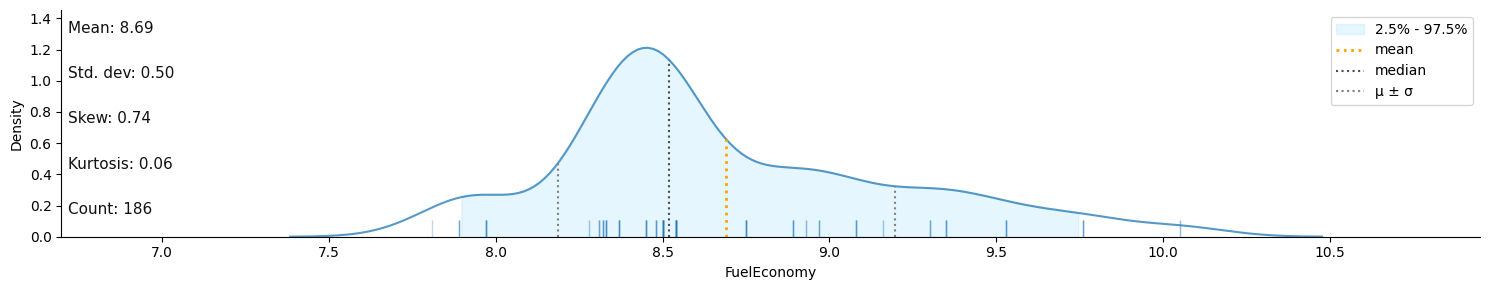

In [13]:
# MNAR 여부 판단하기 위해 특별히 높거나 낮은 수치에서의 결측치 발생 여부 확인 위해 FuelEconomy 값의 분포 확인

klib.dist_plot(df['FuelEconomy']) # 범주형 자료의 경우 car_plot

#### 그래프 해석
- 연비에 대해 상식과 어긋날 정도로 분포의 특정 부분 누락되었다고 의심하기 어려움! 정규분포에 가까움! -> MNAR 유형 아닐 것!

### 2) 결측치 제거: MCAR or MAR이면서 결측의 원인이 분석하고자 하는 변수와 무관한 경우
- 완전 제거(Listwise Deletion): 결측치가 하나라도 존재하는 행을 모두 삭제
  * 결측 비율이 5% 미만으로 매우 낮을 떄
  * MCAR이 확실할 때
  * 샘플 크키가 충분히 클 때(n>1000)
  * 단순 분석이나 탐색적 분석 시
- 부분 제거(Pairwise Deletion): 분석에 사용할 속성에 결측치가 있는 경우만 삭제
  * 상관관계나 공분산 분석 시
  * 변수별 결측 패턴이 다를 때
  * 각 변수쌍의 관계만 중요할 때
  * MCAR or 약한 MAR

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            205 non-null    object 
 1   StartTime       205 non-null    object 
 2   DayOfWeek       205 non-null    object 
 3   GoingTo         205 non-null    object 
 4   Distance        205 non-null    float64
 5   MaxSpeed        205 non-null    float64
 6   AvgSpeed        205 non-null    float64
 7   AvgMovingSpeed  205 non-null    float64
 8   FuelEconomy     188 non-null    object 
 9   TotalTime       205 non-null    float64
 10  MovingTime      205 non-null    float64
 11  Take407All      205 non-null    object 
 12  Comments        24 non-null     object 
dtypes: float64(6), object(7)
memory usage: 20.9+ KB
None


In [17]:
# 완전 제거
df_dropped = df.dropna()
print(df_dropped.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 15 to 189
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            23 non-null     object 
 1   StartTime       23 non-null     object 
 2   DayOfWeek       23 non-null     object 
 3   GoingTo         23 non-null     object 
 4   Distance        23 non-null     float64
 5   MaxSpeed        23 non-null     float64
 6   AvgSpeed        23 non-null     float64
 7   AvgMovingSpeed  23 non-null     float64
 8   FuelEconomy     23 non-null     object 
 9   TotalTime       23 non-null     float64
 10  MovingTime      23 non-null     float64
 11  Take407All      23 non-null     object 
 12  Comments        23 non-null     object 
dtypes: float64(6), object(7)
memory usage: 2.5+ KB
None


In [18]:
# 부분 제거
df_dropped = df.dropna(subset = ['FuelEconomy', 'Date']) # 결측치를 제거하고자 하는 속성 이름 포함
print(df_dropped.info())

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 6 to 201
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            188 non-null    object 
 1   StartTime       188 non-null    object 
 2   DayOfWeek       188 non-null    object 
 3   GoingTo         188 non-null    object 
 4   Distance        188 non-null    float64
 5   MaxSpeed        188 non-null    float64
 6   AvgSpeed        188 non-null    float64
 7   AvgMovingSpeed  188 non-null    float64
 8   FuelEconomy     188 non-null    object 
 9   TotalTime       188 non-null    float64
 10  MovingTime      188 non-null    float64
 11  Take407All      188 non-null    object 
 12  Comments        23 non-null     object 
dtypes: float64(6), object(7)
memory usage: 20.6+ KB
None


### 3) 결측치 대치: 결측치를 적절한 값으로 채워넣음
- 단순 대치(Simple Imputation)
  * 단일값 대치: 임의로 선정한 단일한 값으로 결측치 대체(MCAR 결측치, 결측치 값을 쉽게 예상할 수 있는 경우)
  * 평균/중앙값 대치: 연속형 변수, 결측 비율 5-15%, 정규분포 또는 대칭분포(평균), 왜도가 있는 분포(중앙값), 범주형 변수면서 명확한 최빈 범주가 존재(최빈값), 빠른 처리 필요 시
  * 후보 대치(Substitution): 데이터셋 임의로 표집했을 경우 -> 결측치가 발생한 행을 표집에 사용하지 않은 다른 데이터로 대치(Hot deck 전략, Cold deck 전략 활용)
  * 전/후방 대치: 이전/이후에 관측된 값으로 결측치 대체(시계열 데이터, 연속적 관측값, 짧은 결측 구간(1-3개 연속), 값 변화 완만)
  * 보간법(interpolation): 직전/직후의 유효값들을 참고하여 적절히 계산된 값으로 결측치 대체(시계열 데이터, 연속적 관측값, 짧은 결측 구간(1-3개 연속), 값 변화 완만)
- 고급 대치(Advanced Imputation): 분포와 변수 간 관계 보존하기 위해
  * 회귀 대치: 결측값이 있는 행의 다른 변수들로부터 결측값 예측(예측변수와 강한 선형관계, MAR 가정 충족, 예측변수에 결측치 없음)
  * KNN 대치: 결측값에 가장 가까운 이웃(k-NN)을 추적(유사한 관측치들이 존재, 변수 간 상관관계가 명확, 결측 비율 10-30%, 연속형/범주형 혼합 데이터)

In [19]:
# 단일값 대치(single imputation)
df['FuelEconomy'] = pd.to_numeric(df['FuelEconomy'], errors='coerce')

df_filled = df.fillna(0)
df_filled_2 = df.fillna(100)


print(f"원본: {df['FuelEconomy'].mean()}, 대치(0): {df_filled['FuelEconomy'].mean()}, 대치(100): {df_filled_2['FuelEconomy'].mean()}")

원본: 8.690591397849461, 대치(0): 7.885121951219511, 대치(100): 17.153414634146344


In [20]:
# 단순 평균 대치
df_filled_mean = df.fillna(df['FuelEconomy'].mean())

print(f"원본: {df['FuelEconomy'].mean()}, 평균: {df_filled_mean['FuelEconomy'].mean()}")

원본: 8.690591397849461, 평균: 8.690591397849463


In [21]:
# 전방 대치(Last Observation Carried Forward, LOCF) / 후방 대치(Baseline Observation Carried Forward, BOCF)
df_bocf = df.bfill() # backward fill: 뒤쪽에서 발견된 가장 가까운 유효값으로 결측치 채움
df_locf = df.ffill() # forward fill: 앞쪽에서 발견된 가장 가까운 유효값으로 결측치 채움

print(df_bocf.head())
print(df_locf.head())

       Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0  1/6/2012     16:37     Friday    Home     51.29     127.4      78.3   
1  1/6/2012     08:20     Friday     GSK     51.63     130.3      81.8   
2  1/4/2012     16:17  Wednesday    Home     51.27     127.4      82.0   
3  1/4/2012     07:53  Wednesday     GSK     49.17     132.3      74.2   
4  1/3/2012     18:57    Tuesday    Home     51.15     136.2      83.4   

   AvgMovingSpeed  FuelEconomy  TotalTime  MovingTime Take407All  \
0            84.8         8.89       39.3        36.3         No   
1            88.9         8.89       37.9        34.9         No   
2            85.8         8.89       37.5        35.9         No   
3            82.9         8.89       39.8        35.6         No   
4            88.1         8.89       36.8        34.8         No   

            Comments  
0  Put snow tires on  
1  Put snow tires on  
2  Put snow tires on  
3  Put snow tires on  
4  Put snow tires on  
       D

In [22]:
# 보간법(interpolation)
# 선형보간(linear interpolation): 전후의 유효값의 산술평균에 의존하는 보간법
df_interpolated = df.copy()
df_interpolated['FuelEconomy'] = df['FuelEconomy'].interpolate()

print(df[35:42])
print(df_interpolated[35:42])

          Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
35   12/1/2011     07:24   Thursday     GSK     51.38     124.6      80.1   
36  11/30/2011     16:11  Wednesday    Home     51.09     128.7      71.5   
37  11/30/2011     07:19  Wednesday     GSK     51.71     125.6      76.3   
38  11/29/2011     16:52    Tuesday    Home     51.00     121.4      68.4   
39  11/29/2011     07:23    Tuesday     GSK     51.74     112.2      55.3   
40  11/28/2011     16:16     Monday    Home     51.05     128.2      72.4   
41  11/28/2011     07:26     Monday     GSK     51.63     127.1      71.0   

    AvgMovingSpeed  FuelEconomy  TotalTime  MovingTime Take407All    Comments  
35            84.4          NaN       38.5        36.5         No         NaN  
36            76.7          NaN       42.9        39.9         No         NaN  
37            81.8          NaN       40.7        37.9         No         NaN  
38            75.4          NaN       44.7        40.6         

In [23]:
# 시간의 흐름에 따른 보간법
df_interpolated = df.copy()
df_interpolated['Date'] = pd.to_datetime(df_interpolated['Date']) # 문자열 -> 날짜형으로 변경
df_interpolated = df_interpolated.set_index('Date') # 날짜를 인덱스로 설정
df_interpolated['FuelEconomy'] = df_interpolated['FuelEconomy'].interpolate(method='time')

print(df[35:42])
print(df_interpolated[35:42])

          Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
35   12/1/2011     07:24   Thursday     GSK     51.38     124.6      80.1   
36  11/30/2011     16:11  Wednesday    Home     51.09     128.7      71.5   
37  11/30/2011     07:19  Wednesday     GSK     51.71     125.6      76.3   
38  11/29/2011     16:52    Tuesday    Home     51.00     121.4      68.4   
39  11/29/2011     07:23    Tuesday     GSK     51.74     112.2      55.3   
40  11/28/2011     16:16     Monday    Home     51.05     128.2      72.4   
41  11/28/2011     07:26     Monday     GSK     51.63     127.1      71.0   

    AvgMovingSpeed  FuelEconomy  TotalTime  MovingTime Take407All    Comments  
35            84.4          NaN       38.5        36.5         No         NaN  
36            76.7          NaN       42.9        39.9         No         NaN  
37            81.8          NaN       40.7        37.9         No         NaN  
38            75.4          NaN       44.7        40.6         

In [24]:
# 평균 대치(mean imputation)
from sklearn.impute import SimpleImputer

df_imputed = df.copy()
imputer = SimpleImputer(strategy='mean') # SimpleImputer: 결측값(NaN)을 자동으로 채워주는 클래스, 결측값을 평균값으로 채움(median, most_frequent, constant)
df_imputed['FuelEconomy'] = imputer.fit_transform(df[['FuelEconomy']]) # 연비 열만 가져옴 (DataFrame 형태로), NaN 자리에 평균값 계산해서 채움

print(f"원본: {df['FuelEconomy'].mean()}, 대치(평균): {df_imputed['FuelEconomy'].mean()}")

원본: 8.690591397849461, 대치(평균): 8.690591397849463


In [25]:
# 회귀 대치(regression imputation)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# 결측치가 존재하는 특성들(종속변수)
missing_vars = ['FuelEconomy']
# 결측치를 예측하기 위한 특성들(독립변수)
predictor_vars = ['MovingTime', 'AvgMovingSpeed']

# 다른 변수들을 기반으로 연속형 데이터의 결측값을 머신러닝 모델로 예측, 반복(iterative) 방식으로 여러 번 계산하여 더 정확한 값 얻음
imputer = IterativeImputer(estimator=BayesianRidge()) # 예측 모델로 BayesianRidge Regression((정규화된 선형회귀 모델)

imputed_df = imputer.fit_transform(df[missing_vars + predictor_vars]) # df[['FuelEconomy', 'MovingTime', 'AvgMovingSpeed']]
df_imputed = df.copy()
df_imputed['FuelEconomy'] = imputed_df[:, 0] # 전체 행, 첫째 열(FuelEconomy)만 가져옴

print(df.head())
print(df_imputed.head())

       Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0  1/6/2012     16:37     Friday    Home     51.29     127.4      78.3   
1  1/6/2012     08:20     Friday     GSK     51.63     130.3      81.8   
2  1/4/2012     16:17  Wednesday    Home     51.27     127.4      82.0   
3  1/4/2012     07:53  Wednesday     GSK     49.17     132.3      74.2   
4  1/3/2012     18:57    Tuesday    Home     51.15     136.2      83.4   

   AvgMovingSpeed  FuelEconomy  TotalTime  MovingTime Take407All Comments  
0            84.8          NaN       39.3        36.3         No      NaN  
1            88.9          NaN       37.9        34.9         No      NaN  
2            85.8          NaN       37.5        35.9         No      NaN  
3            82.9          NaN       39.8        35.6         No      NaN  
4            88.1          NaN       36.8        34.8         No      NaN  
       Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0  1/6/2012     16:37    

In [26]:
# KNN 대치(K-Nearest Neighbor): 결측치가 범주형이면 이웃 집단의 최빈값, 연속형이면 중앙값 사용
from sklearn.impute import KNNImputer

# 가까운 이웃 k개(K-nearest neighbors)의 값 평균으로 채움
knn = KNNImputer(n_neighbors=4, weights='uniform') # 4개의 이웃을 동일한 가중치(그냥 평균)로 처리
data = knn.fit_transform(df[['FuelEconomy']])
df_imputed = df.copy()
df_imputed['FuelEconomy'] = data

print(df_imputed.head())

       Date StartTime  DayOfWeek GoingTo  Distance  MaxSpeed  AvgSpeed  \
0  1/6/2012     16:37     Friday    Home     51.29     127.4      78.3   
1  1/6/2012     08:20     Friday     GSK     51.63     130.3      81.8   
2  1/4/2012     16:17  Wednesday    Home     51.27     127.4      82.0   
3  1/4/2012     07:53  Wednesday     GSK     49.17     132.3      74.2   
4  1/3/2012     18:57    Tuesday    Home     51.15     136.2      83.4   

   AvgMovingSpeed  FuelEconomy  TotalTime  MovingTime Take407All Comments  
0            84.8     8.690591       39.3        36.3         No      NaN  
1            88.9     8.690591       37.9        34.9         No      NaN  
2            85.8     8.690591       37.5        35.9         No      NaN  
3            82.9     8.690591       39.8        35.6         No      NaN  
4            88.1     8.690591       36.8        34.8         No      NaN  
